In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
import numpy as np
from scipy.spatial import KDTree
from scipy.stats import binom
import pandas as pd

rng = np.random.default_rng(16558947)

class environment():
    def __init__(self, Nagents, inter_distance, inter_rate, birth_rate, taus, g_sqrts, centers, dispersal_kernel, data_interval=50, h=1e-3, env_size=1e2, seed=34567, rng=None, id=None, transient_steps=1000, check_termination_N_data=40):

        self.id = id
        
        # Setup random number generator
        if rng is None:
            self.rng = np.random.default_rng(seed)
        else:
            self.rng = rng

        # Environment properties
        self.env_size = env_size
        self.h = h
        self.t = 0.
        self.steps = 0

        # Number, interactions
        self.N = Nagents
        self.birth_rate = birth_rate
        self.interaction_distance = inter_distance
        self.interaction_rate = inter_rate#1./(np.pi*inter_distance*inter_distance)

        self.births = 0
        self.deaths = 0

        # Dispersal kernel
        # assume a gaussian dispersal kernel with stdev dispersal_kernel
        self.dispersal_kernel = dispersal_kernel

        # Position
        if centers == 'random':
            self.centers = self.rng.uniform(high=env_size, size=(self.N, 2))
        else:
            self.centers = centers
        self.x = self.centers
        # interaction-related
        self.positions_tree = KDTree(self.centers, compact_nodes=False, balanced_tree=False)
        self.possible_interacting_pairs = None
        self.n_interacting_pairs = None
        
        # Stochastic properties
        self.taus = taus
        self.g_sqrts = g_sqrts
        self.Z = np.zeros((1000,1000))

        # OU_movement generator
        self.OU_mover = milshtein_OU_N_2D(rng=self.rng, x0=self.x, tau=self.taus, center=self.centers, g_sqrt=self.g_sqrts, h=self.h, N=self.N)

        # Gillespie variables
        self.total_rate = 0.
        self.total_birth_rate = 0.
        self.total_interaction_rate = 0.

        # Stored data
        self.data = pd.DataFrame(columns=['t', 'events', 'N', 'rep', 'tau', 'inter', 'interRate', 'birthRate', 'births',
       'deaths'])
        self.data_interval = data_interval

        # Termination
        self.check_termination_N_data = check_termination_N_data
        self.theoretical_equilibrium_CDF = self.generate_binom_theoreticalCDF(self.data_interval, .5)
        #(avoid error for lack of data in function call)
        self.transient_steps = np.max([transient_steps, self.check_termination_N_data*self.data_interval])

    def run(self, max_steps):
        self.t = 0.
        self.steps = 0
        while self.steps < max_steps:
            # perform a gillespie step
            self.gillespie_step()
            self.steps += 1

            # record data 
            if self.steps % self.data_interval == 0:
                self.store_data()
                self.births = 0
                self.deaths = 0
                
                # check termination
                if self.steps > self.transient_steps:
                    if self.stop_condition():
                        break

            # shouldn't happen
            if self.N == 0:
                break
    
    def update_Z(self, pos, ndivs=1000):
        x = round(pos[0,0]*ndivs)
        y = round(pos[0,1]*ndivs)
        self.Z[x, y] += 1.

    def gillespie_step(self):

        # calculate all possible interaction rates
        self.calculate_rates()

        # calculate residence time
        delta_t = rng.exponential(scale=1/self.total_rate)

        # choose process
        probabilites = np.array([self.total_birth_rate, self.total_interaction_rate])
        probabilites = probabilites/np.sum(probabilites)
        isbirth = rng.choice([True, False], p=probabilites)

        # implement birth
        if isbirth:
            # choose randomly which individual gave birth
            repr_id = rng.integers(self.N)
            # update birth
            self.update_birth(repr_id=repr_id)

        # implement interaction (death)
        else:
            # choose randomly which pair interacted
            interacting_pair = self.possible_interacting_pairs[rng.integers(self.n_interacting_pairs)]
            # choose randomly which individual of the pair died
            dead_id = rng.choice(interacting_pair)
            # update death
            self.update_death(dead_id=dead_id)

        # move everyone
        self.move(delta_t=delta_t)

        # update time
        self.t += delta_t

    def calculate_rates(self):
        # total birth rate
        self.total_birth_rate = self.birth_rate * self.N

        # total interaction rate
        self.calc_interaction_pairs()
        self.total_interaction_rate = self.interaction_rate * self.n_interacting_pairs

        # total rate
        self.total_rate = self.total_interaction_rate + self.total_birth_rate

    def update_birth(self, repr_id):
        # disperse center of new individual
        # INFO Gaussian Distribution Kernel
        # new_center = rng.normal(loc=self.x[repr_id], scale=self.dispersal_kernel, size=2)[np.newaxis,:]
        # new_center = new_center % self.env_size
        # INFO Random new center
        new_center = self.env_size*rng.random(size=2)[np.newaxis,:]

        # update positions, centers and number of individuals
        self.x = np.concatenate((self.x, new_center), axis=0)
        self.centers = np.concatenate((self.centers, new_center), axis=0)
        self.N += 1
        self.births += 1

        # update the 'mover'
        self.OU_mover = milshtein_OU_N_2D(rng=self.rng, x0=self.x, tau=self.taus, center=self.centers, g_sqrt=self.g_sqrts, h=self.h, N=self.N)

    def update_death(self, dead_id):
        # update positions, centers and number of individuals
        self.x = np.delete(self.x, dead_id, axis=0)
        self.centers = np.delete(self.centers, dead_id, axis=0)
        self.N -= 1
        self.deaths += 1

        # update the 'mover'
        self.OU_mover = milshtein_OU_N_2D(rng=self.rng, x0=self.x, tau=self.taus, center=self.centers, g_sqrt=self.g_sqrts, h=self.h, N=self.N)

    def move(self, delta_t):
        self.x = self.OU_mover(delta_t)
        self.periodic_boundary_conditions()
        # self.update_Z(self.x)

    def periodic_boundary_conditions(self):
        self.x = self.x % self.env_size

    def stop_condition(self):
        # identify if the number of births follows a binomial (gaussian) distribution    
        # N = self.data_interval

        X = self.data['births'][-self.check_termination_N_data:]

        # test if there is a sufficient number of observations
        # if N > 9:

        # test if skewness is sufficiently low
        # if skew(X) < 1/3:

        # test if observations follow a gaussian distribution and return
        # test if p-value is greater than .5
        # (20% of kstests with the same RVS and CDF generate p-value > .5)
        # return kstest(rvs=X, cdf='binom', args=(N, .5))[1] > .5

        # 0.065 is roughly the 17% quantile of the distribution of kolmogorov_like_test
        # when empirical CDF was generated from the theoretical CDF (scipy rvs method)
        # i.e. the distributions are considered equal under a quite restrictive assumption
        # as a comparison, afirming distributions are different by rejection of the null hypothesis 
        # at the alpha=0.05 level requires the measure to larger than 0.21 [based on New Cambridge stat tables]

        CDFn = self.generate_CDF(X, self.data_interval)
        return self.kolmogorov_like_test(CDFn, self.theoretical_equilibrium_CDF) <= .1#.065
    
    @staticmethod
    def kolmogorov_like_test(CDFn, CDFtheo):
        # N = CDFn.shape[0]
        # assert CDFtheo.shape == CDFn.shape, "CDFs must have the same shape"

        # returns the maximum absolute difference between the theoretical and empirical CDFs
        return np.max(np.abs(CDFn-CDFtheo))

    @staticmethod
    def generate_CDF(X, N):
        """Receives a vector of observations and returns the empirical CDF with support [0,N].

        Args:
            X (np.array): Vector of observations
            N (int): upper limit of the support

        Returns:
            np.array: The vector containing the values of the empirical CDF. Output is a N+1 dimensional numpy vector.
        """
        
        # All but the last (righthand-most) bin is half-open.
        # the last bin need to be [N, N+1]
        bin_limits = np.arange(0,N+2)
        CDF = np.histogram(X, bins=bin_limits, density=True)[0].cumsum()
        return CDF

    @staticmethod
    def generate_binom_theoreticalCDF(N, p):
        """Generates the theoretical CDF of the binomial distribution with $N$ samples and probability of success $p$.

        Args:
            N (int): Number of samples
            p (float): probability of success

        Returns:
            np.array: The vector containing the values of the theoretical CDF. Output is a N+1 dimensional numpy vector.
        """
        dist = binom(N, p)
        xs = np.arange(0,N+1)
        CDF = dist.cdf(xs)
        return CDF

    def calc_interaction_pairs(self):
        self.positions_tree = KDTree(self.x, compact_nodes=False, balanced_tree=False)
        self.possible_interacting_pairs = self.positions_tree.query_pairs(self.interaction_distance, output_type='ndarray')
        self.n_interacting_pairs = len(self.possible_interacting_pairs)

    def store_data(self):
        self.data = self.data.append({'events': self.steps, 't': self.t, 'N': self.N, 'rep': self.id, 'tau': self.taus, 'inter': self.interaction_distance, 'interRate':self.total_interaction_rate, 'birthRate': self.total_birth_rate, 'births': self.births, 'deaths': self.deaths}, ignore_index=True)

class milshtein_OU_N_2D:
    #
    # OU model:
    # dX = -(1/tau)*(X - center)*dt + sqrt(g)*dW
    # dW is white noise
    #
    def __init__(self, rng, x0, tau, center, g_sqrt, h, N):
        # random number generator
        self.rng = rng
        # time-step
        self.h = h
        # number of independent 'movers'
        self.N = int(N)
        # Process parameters (all of them are numpy vectors!)
        self.tau = tau # shape = (N,2)
        self.g_sqrt = g_sqrt # shape = (N,2) 
        self.xi = x0 # shape = (N,2)
        self.center = center # shape = (N,2)

        # Auxiliary Variables
        self.h_sqrt = np.sqrt(h)
        # self.g_sqrt = np.sqrt(g)

    def __call__(self, delta_t):
        # number of time intervals to be considered
        intervals = int(np.ceil(delta_t/self.h))

        # generate all random values at once
        uh = self.h_sqrt*self.rng.normal(size=(self.N, 2, intervals))
        
        for i in range(intervals):
            self.xi += uh[:,:,i]*self.g_sqrt + self.h*(self.center - self.xi)/self.tau
        return self.xi

def run_environment(dic):
    id = 'tau='+str(dic['taus']) +'_inter='+str(dic['int'])+'_rep='+str(dic['rep'])
    env = environment(Nagents=100, inter_distance=dic['int'], birth_rate=1., inter_rate=1., taus=dic['taus'], g_sqrts=1., centers='random', dispersal_kernel='random', data_interval=50, env_size=1., id=dic['rep'])
    env.run(int(1e4))
    np.save('np_centers/'+id, env.centers)
    return env.data

def fix_df(df):
    ls = []
    for id, it in df.iterrows():
        ls.append(it[0])
    
    return pd.DataFrame(ls)

def store_data(data, columns = ['t', 'N', 'rep', 'tau', 'inter', 'interRate', 'birthRate', 'births', 'deaths']):
    df = pd.DataFrame(columns=columns)
    for d in data:
        # print(d)
        # input()
        auxdf = pd.DataFrame(d)#, index=[0])
        # print(auxdf)
        # input()
        df = pd.concat([df, auxdf], ignore_index=True)
        # for d in container:
    return df

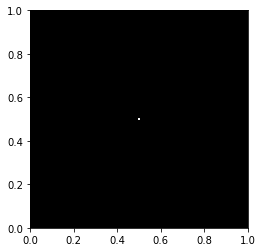

In [138]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np


rng = np.random.default_rng()

## PREPARE DATA

class milshtein_OU_N_2D:
    #
    # OU model:
    # dX = -(1/tau)*(X - center)*dt + sqrt(g)*dW
    # dW is white noise
    #
    def __init__(self, rng, x0, tau, center, g_sqrt, h, N, env_size=1.):
        # random number generator
        self.rng = rng
        # time-step
        self.h = h
        # number of independent 'movers'
        self.N = int(N)
        # Process parameters (all of them are numpy vectors!)
        self.tau = tau # shape = (N,2)
        self.g_sqrt = g_sqrt # shape = (N,2) 
        self.xi = x0 # shape = (N,2)
        self.center = center # shape = (N,2)
        self.env_size = env_size # float

        # Auxiliary Variables
        self.h_sqrt = np.sqrt(h)
        # self.g_sqrt = np.sqrt(g)

    def __call__(self, delta_t):
        # number of time intervals to be considered
        intervals = int(np.ceil(delta_t/self.h))

        # generate all random values at once
        uh = self.h_sqrt*self.rng.normal(size=(self.N, 2, intervals))
        
        for i in range(intervals):
            self.xi += uh[:,:,i]*self.g_sqrt + self.h*(self.center - self.xi)/self.tau

        # self.xi = self.xi % self.env_size
        return self.xi

mover = milshtein_OU_N_2D(rng=rng, tau=1e-5, g_sqrt=1e-1, x0=np.array([[.5, .5]]), h=1e-6, N=1, center=np.array([[.5, .5]]))
mover.dots = mover.xi

step = 1e-2

steps_per_frame = 40
n_frames = 240
n_steps = steps_per_frame*n_frames

for _ in range(n_steps):
    mover(step)
    # mover.t += step
    mover.dots = np.concatenate((mover.dots, mover.xi), axis = 0)

# AUX FUNCTIONS

def distance(x0, x1, dimensions=1):
    delta = np.abs(x0 - x1)
    delta = np.where(delta > 0.5 * dimensions, delta - dimensions, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

def within_boundaries(x0, x1, dimensions=1):
    # return True if smallest distance is within the boundaries
    delta = np.abs(x0 - x1)
    return np.all(delta < 0.5 * dimensions)

# SETUP

line_list = []
#number of line segments to retain in blue before greying them out
line_delay = 1

def init():
    ax.clear()
    #you can omit the fixed scales, then they will be automatically updated
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_facecolor('k')
    ax.set_aspect(1.)

def update(i):
    #initializing the plot, emptying the line list 
    # if not i:
    #     init()
    #     line_list[:] = []
    
    #set line color to grey if delay number is exceeded
    # if len(line_list)>=line_delay:
    #     line_list[-line_delay].set_color("grey")
    
    #plot new line segment
    if i == 0:
        lims = (0, steps_per_frame)
    else:
        lims = steps_per_frame*i-1,(i+1)*steps_per_frame

    for j in range(*lims):
        x0 = mover.dots[j]
        xf = mover.dots[j+1]

        if within_boundaries(x0, xf):
            # newsegm, = ax.plot(*env.dots.T[:, steps_per_frame*i-1:(i+1)*throttle], color="white", linewidth=.5) 
            newsegm, = ax.plot([x0[0], xf[0]], [x0[1], xf[1]], color="white", linewidth=.5) 
            line_list.append(newsegm)
            

fig,ax = plt.subplots()

init()
ani = anim.FuncAnimation(fig, update, init_func=init, frames = np.arange(24), repeat=True)
FFwriter = animation.FFMpegWriter(fps=6, bitrate=-1, codec="h264")

ani.save('teste4.mp4', writer=FFwriter, dpi=300)

array([[0.46691829, 0.4851368 ],
       [0.39135945, 0.61226557],
       [0.44389427, 0.81641047],
       [0.4051583 , 0.31326686],
       [0.40901558, 0.58635352],
       [0.63555748, 0.56734727],
       [0.50685188, 0.65239607],
       [0.45883942, 0.34623932],
       [0.45847097, 0.53655268],
       [0.2250848 , 0.2569482 ],
       [0.52708984, 0.41293871],
       [0.20994538, 0.30156594],
       [0.32479349, 0.65631234],
       [0.13851105, 0.85495891],
       [0.67785777, 0.9638123 ],
       [0.52608541, 0.13382508],
       [0.44136715, 0.61264795],
       [0.53272322, 0.24207612],
       [0.45528849, 0.68654037],
       [0.04378153, 0.86022949]])

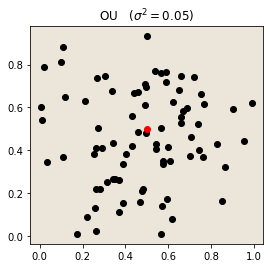

In [189]:
fig, ax = plt.subplots()

ax.set_aspect(1.)
ax.set_facecolor('#ebe6d9')

rng = np.random.default_rng()
vals = rng.multivariate_normal(np.array([.5, .5]), cov=np.array([[.05, 0.], [0., .05]]), size=(80)) % 1.

ax.scatter(*vals.T, color='k')
ax.scatter(.5, .5, color='r')

plt.title("OU   ($\sigma^2 = 0.05$)")
fig.savefig("OU.png")

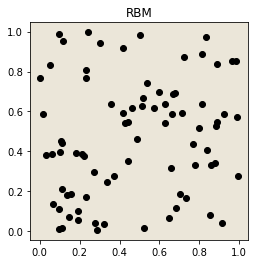

In [185]:
fig, ax = plt.subplots()

ax.set_aspect(1.)
ax.set_facecolor('#ebe6d9')

rng = np.random.default_rng()
vals = rng.multivariate_normal(np.array([.5, .5]), cov=np.array([[5, 0.], [0., 5]]), size=(80)) % 1.

ax.scatter(*vals.T, color='k')

plt.title("RBM")
fig.savefig("RBM.png")

Text(0.5, 1.0, 'OU \n $\\sigma^2 = 0.05$')

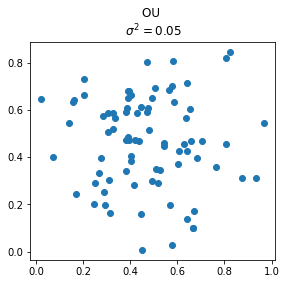

In [ ]:
fig, ax = plt.subplots()

ax.set_aspect(1.)

rng = np.random.default_rng()
vals = rng.multivariate_normal(np.array([.5, .5]), cov=np.array([[.05, 0.], [0., .05]]), size=(80)) % 1.

ax.scatter(*vals.T)

plt.title("RBM")

/tmp/ipykernel_713368/1780427408.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if centers == 'random':


IndexError: index 9601 is out of bounds for axis 0 with size 9601

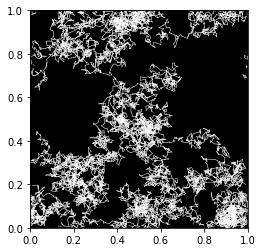

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import numpy as np


## PREPARE DATA

env = environment(Nagents=1, inter_distance=.1, birth_rate=1., inter_rate=1., taus=1e-4, g_sqrts=1e-1, centers=np.array([[.5, .5]]), dispersal_kernel='random', env_size=1., seed=6)
env.dots = env.x

step = 1e-2

steps_per_frame = 40
n_frames = 240
n_steps = steps_per_frame*n_frames

for _ in range(n_steps):
    env.move(step)
    env.t += step
    env.dots = np.concatenate((env.dots, env.x), axis = 0)

# AUX FUNCTIONS

def distance(x0, x1, dimensions=1):
    delta = np.abs(x0 - x1)
    delta = np.where(delta > 0.5 * dimensions, delta - dimensions, delta)
    return np.sqrt((delta ** 2).sum(axis=-1))

def within_boundaries(x0, x1, dimensions=1):
    # return True if smallest distance is within the boundaries
    delta = np.abs(x0 - x1)
    return np.all(delta < 0.5 * dimensions)

# SETUP

line_list = []
#number of line segments to retain in blue before greying them out
line_delay = 1

def init():
    ax.clear()
    #you can omit the fixed scales, then they will be automatically updated
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_facecolor('k')
    ax.set_aspect(1.)

def update(i):
    # TODO: aggregate all segments that don't cross the border
    #plot new line segment
    if i == 0:
        lims = (0, steps_per_frame)
    else:
        lims = steps_per_frame*i-1,(i+1)*steps_per_frame

    for j in range(*lims):
        # BUG avoid IndexError by skipping last plot (j+1) out of range
        x0 = env.dots[j]
        xf = env.dots[j+1]

        if within_boundaries(x0, xf):
            # newsegm, = ax.plot(*env.dots.T[:, steps_per_frame*i-1:(i+1)*throttle], color="white", linewidth=.5) 
            newsegm, = ax.plot([x0[0], xf[0]], [x0[1], xf[1]], color="white", linewidth=.5) 
            line_list.append(newsegm)
            

fig,ax = plt.subplots()

init()
ani = anim.FuncAnimation(fig, update, init_func=init, frames = np.arange(480), repeat=True)
FFwriter = animation.FFMpegWriter(fps=24, bitrate=-1, codec="h264")

ani.save('teste5.mp4', writer=FFwriter, dpi=300)

/tmp/ipykernel_387365/1780427408.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if centers == 'random':


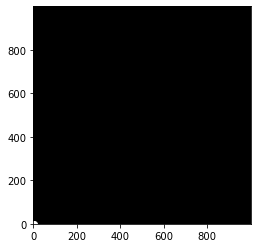

In [21]:
ndivs = 1000

fig, ax = plt.subplots()

ax.set_aspect(1.)
fig.set_facecolor("#ffffff00")

env = environment(Nagents=1, inter_distance=.1, birth_rate=1., inter_rate=1., taus=1e1, g_sqrts=1e0, centers=np.array([[.5, .5]]), dispersal_kernel='random', env_size=1.)
env.Z = np.zeros((ndivs, ndivs))
im = ax.imshow(env.Z, aspect=1., interpolation='none', vmin=0., vmax=1, cmap='gray', origin='lower')
points=ax.plot(env.x.T[0], env.x.T[1],'o', color='white')

def animate(i):
    t=1e-2
    env.move(t)
    env.t += t
    im.set_array(env.Z.T)
    ax.set_title(f"BM Movement \n $\\tau \\rightarrow \infty$ $\sigma = 0.01$ $t = ${env.t:.1e}")
    for idx, p in enumerate(points):
        p.set_data(ndivs*env.x.T[0], ndivs*env.x.T[1])
    return [im, *points]

lin_ani=animation.FuncAnimation(fig, animate, frames=1000)
# plt.legend()

FFwriter = animation.FFMpegWriter(fps=60, bitrate=-1, codec="h264")
# FFwriter = animation.FFMpegFileWriter()
lin_ani.save('BM.mp4', writer=FFwriter, dpi=300)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def asympt_distr(x, y, centers, stdev):
    """The idea is to calculate the cumulative probability density of an individual occuppying some spot

    Args:
        x (_type_): _description_
        y (_type_): _description_
        centers (_type_): _description_
        stdev (_type_): _description_

    Returns:
        _type_: _description_
    """
    point_vec = np.array([x,y])
    normal_dis = point_vec - centers
    normal_dis = -np.sum(normal_dis*normal_dis, axis=1)/(2*stdev*stdev)
    normal_dis = np.exp(normal_dis)
    normal_dis = normal_dis/(stdev*np.sqrt(2.*np.pi))
    return np.sum(normal_dis)


# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

x = np.arange(0., env_size, dx)
y = np.arange(0., env_size, dy)
X, Y = np.meshgrid(x, y)
Y = Y[::-1]

# when layering multiple images, the images need to have the same
# extent.  This does not mean they need to have the same shape, but
# they both need to render to the same coordinate system determined by
# xmin, xmax, ymin, ymax.  Note if you use different interpolations
# for the images their apparent extent could be different due to
# interpolation edge effects

nx, ny = X.shape

Z = np.zeros((nx,ny))

centers = np.array(u)

# periodic boundary conditions:
centers = add_ghost_points(centers=centers, n_cell_divisions=n_cell_divisions, cell_index=cell_index, env_size=env_size)

g = 1.
tau = 0.001
stdev = np.sqrt(g*tau/2)

for i in range(nx):
    for j in range(ny):
        Z[i,j] = asympt_distr(X[i,j], Y[i,j], centers=centers, stdev=stdev)

extent = np.min(x), np.max(x), np.min(y), np.max(y)

NameError: name 'u' is not defined

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def asympt_distr(x, y, centers, stdev):
    """The idea is to calculate the cumulative probability density of an individual occuppying some spot

    Args:
        x (_type_): _description_
        y (_type_): _description_
        centers (_type_): _description_
        stdev (_type_): _description_

    Returns:
        _type_: _description_
    """
    point_vec = np.array([x,y])
    normal_dis = point_vec - centers
    normal_dis = -np.sum(normal_dis*normal_dis, axis=1)/(2*stdev*stdev)
    normal_dis = np.exp(normal_dis)
    normal_dis = normal_dis/(stdev*np.sqrt(2.*np.pi))
    return np.sum(normal_dis)


# make these smaller to increase the resolution
dx, dy = 0.01, 0.01

env_size = 1.

x = np.arange(0., env_size+dx, dx)
y = np.arange(0., env_size+dy, dy)
X, Y = np.meshgrid(x, y)
Y = Y[::-1]

# when layering multiple images, the images need to have the same
# extent.  This does not mean they need to have the same shape, but
# they both need to render to the same coordinate system determined by
# xmin, xmax, ymin, ymax.  Note if you use different interpolations
# for the images their apparent extent could be different due to
# interpolation edge effects

nx, ny = X.shape

Z = np.zeros((nx,ny))

for i in range(nx):
    for j in range(ny):
        Z[i,j] = rng.random()

extent = np.min(x), np.max(x), np.min(y), np.max(y)

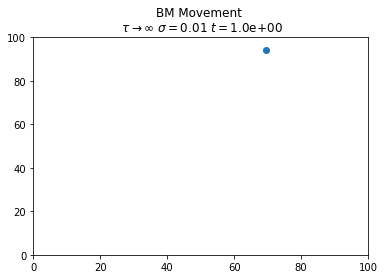

In [67]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

# plt.rcParams['animation.ffmpeg_path'] ='C:\\ffmpeg\\bin\\ffmpeg.exe'
fig, ax = plt.subplots()

fig.set_facecolor("#ffffff00")

env = environment(Nagents=1, inter_distance=.1, birth_rate=1., inter_rate=1., taus=1e1, g_sqrts=1e-1, centers='random', dispersal_kernel='random', env_size=1.)

cmap = ListedColormap(get_cmap('viridis')(np.linspace(.73, 0.79, 32)))
# im = ax.imshow(Z, cmap=cmap, interpolation='bilinear',extent=extent)

# x=np.linspace(100,150,100)
# t=(x-100)/0.5
# y=-.01*np.cos(t)+.5*np.sin(t)+100.01
# z=.01*np.sin(t)+.5*np.cos(t)+99.5

def animate(i):
    t=1e-2
    env.move(t)
    env.t += t
    # print(len(points))
    for idx, p in enumerate(points):
        p.set_data(100*env.x.T[0], 100*env.x.T[1])
        ax.set_title(f"BM Movement \n $\\tau \\rightarrow \infty$ $\sigma = 0.01$ $t = ${env.t:.1e}")
    return points

ax.set_xlim([0., 100.])
ax.set_ylim([0., 100.])

ax.set_title("OU Movement t = 0.0")

points=ax.plot(env.x.T[0], env.x.T[1],'o')
lin_ani=animation.FuncAnimation(fig, animate)
# plt.legend()


FFwriter = animation.FFMpegWriter(fps=10, bitrate=-1, codec="h264",)
# FFwriter = animation.FFMpegFileWriter()
lin_ani.save('BM.mp4', writer=FFwriter, dpi=300)

In [17]:
lin_ani.save('A.mp4')

In [24]:
env.x.T[1]

array([0.62831537, 0.40831849, 0.78137929, 0.69520028, 0.18826797,
       0.54329471, 0.69506067, 0.56234913, 0.36536684, 0.76601777,
       0.40457962, 0.98989483, 0.35753463, 0.9547946 , 0.88962541,
       0.08998506, 0.2676465 , 0.31056831, 0.93764031, 0.96748118])

In [17]:
ax.scatter(env.x.T[0], env.x.T[1])

In [ ]:

tmax = 20000;%the maximum time
x = 1;       %the number of particles
n = 400;     %the size of the square grid
pos = randi(n/2,2,x)+n/4; %initial position of particles.
vel = randi(3,2,x)-2;     %initial velocity of particles.
img = zeros(n);
r=1;
for t=1:tmax
    for q=1:50 %how many steps per frame
        img=0.9999*img;%reset the image but with a shadow or trail.
        for i=1:x
            img(pos(1,i),pos(2,i))=img(pos(1,i),pos(2,i))+10;
        end
        vel=randi(3,2,x)-2; %velocity of particles.
        pos=pos+vel;
        pos=mod(pos-1,n)+1;
    end
    imwrite(img./11,[num2str(t) '.png'],'png');
end
